# Step 0. Introduction
**0-1. Import Packages and Data**

In [2]:
# Import Packages
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install shap

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, recall_score, f1_score, roc_auc_score, plot_confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from category_encoders import CatBoostEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
import eli5
from eli5.sklearn import PermutationImportance
import shap

**0-2. 데이터 업로드**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/My Drive/data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Step 1. Data Preprocessing
**1-1. 데이터 타입 변경 및 결측치 처리**

In [5]:
# 데이터 타입 및 결측치 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


**1) 불필요한 컬럼 삭제**

불필요한 컬럼인, customerID 컬럼 삭제

In [6]:
# customerID 컬럼 삭제
df = df.drop('customerID', axis=1)

**2) 데이터 타입 변경 및 결측치 처리**

TotalCharges 컬럼의 데이터 타입이 object로 되어 있기 때문에 이를 변경

In [7]:
# TotalCharges 컬럼 dtype 변경
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].dtype

dtype('float64')

In [8]:
# 해당 컬럼 결측치 확인
df['TotalCharges'].isnull().sum()

11

In [9]:
# 결측 데이터 삭제
df.dropna(inplace=True)
df = df.reset_index(drop=True)

# 전체 결측치 확인
df.isna().sum() # 결측치 없음

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

**1-2. 컬럼 별 데이터 확인**

gender — 고객의 성별

SeniorCitizen — 고객이 노인인지 여부

Partner — 고객에게 파트너가 있는지 여부

Dependents — 고객에게 부양 가족이 있는지 여부

tenure — 고객이 계약을 유지한 개월 수

PhoneService — 고객에게 전화 서비스가 있는지 여부

MultipleLines — 고객에게 여러 회선이 있는지 여부

InternetService — 고객의 인터넷 서비스 제공 업체

OnlineSecurity — 고객의 온라인 보안 여부

OnlineBackup — 고객의 온라인 백업 여부

DeviceProtection — 고객의 기기 보호 여부

TechSupport — 고객의 기술 지원 여부

StreamingTV — 고객이 스트리밍 TV를 가지고 있는지 여부

StreamingMovies — 고객이 스트리밍 영화를 가지고 있는지 여부

Contract — 고객의 계약 기간

PaperlessBilling — 종이 없는 청구서 여부

PaymentMethod — 고객의 결제 방법

MonthlyCharges — 매월 고객에게 청구되는 금액

TotalCharges — 고객에게 청구 된 총 금액

Churn(target) — 고객 이탈 여부

In [12]:
# 컬럼 정보 확인
df.nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Churn                  2
dtype: int64

In [13]:
# 컬럼 별 unique 값 확인
for col in df.columns:
  print(f"{col}: \n{df[col].unique()}\n")

gender: 
['Female' 'Male']

SeniorCitizen: 
[0 1]

Partner: 
['Yes' 'No']

Dependents: 
['No' 'Yes']

tenure: 
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]

PhoneService: 
['No' 'Yes']

MultipleLines: 
['No phone service' 'No' 'Yes']

InternetService: 
['DSL' 'Fiber optic' 'No']

OnlineSecurity: 
['No' 'Yes' 'No internet service']

OnlineBackup: 
['Yes' 'No' 'No internet service']

DeviceProtection: 
['No' 'Yes' 'No internet service']

TechSupport: 
['No' 'Yes' 'No internet service']

StreamingTV: 
['No' 'Yes' 'No internet service']

StreamingMovies: 
['No' 'Yes' 'No internet service']

Contract: 
['Month-to-month' 'One year' 'Two year']

PaperlessBilling: 
['Yes' 'No']

PaymentMethod: 
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

MonthlyCharges: 
[29.85 56.95 53.85 .

**1) SeniorCitizen컬럼 응답 변경**

1/0 응답의 경우, Yes/No 으로 변경

In [14]:
df['SeniorCitizen'] = df['SeniorCitizen'].apply(lambda x: 'Yes' if x == 1 else 'No')

**2) tenure 컬럼**

tenure컬럼의 경우 계약을 유지한 개월 수를 의미하므로, 12개월 즉 1년 단위로 범위를 구분해 정리할 필요가 있음

In [15]:

# max값 확인
df["tenure"].max()  # 최대 72개월 = 최대 6년

72

In [16]:
def transform_tenure(l):
    l2 = []
    for i in l:
        if 1 <= i <= 12:
            l2.append(1)
        elif i <= 24:
            l2.append(2)
        elif i <= 36:
            l2.append(3)
        elif i <= 48:
            l2.append(4)
        elif i <= 60:
            l2.append(5)
        else:
            l2.append(6)
    return(l2)
df['tenure'] = transform_tenure(df['tenure'])

In [17]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,3,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,1,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,4,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Step 2. Exploratory Data Analysis

**2-1. Target : Churn**

고객 이탈 여부, 즉 Churn을 예측하는 것이 목표이기에, 타겟은 Churn여부가 되며 이는 1/0의 이진 분류 문제가 된다.

따라서 먼저 타겟의 비율을 확인할 필요가 있다.

In [18]:
# Churn feature 비율 확인
churn_feature = pd.DataFrame({'Churn count':df['Churn'].value_counts()})
churn_feature['Churn rate(%)'] = (churn_feature['Churn count'] / len(df))*100

churn_feature

,Churn count,Churn rate(%)
No,5163,73.421502
Yes,1869,26.578498


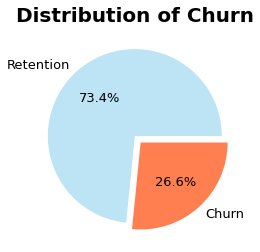

In [19]:
plt.pie(churn_feature['Churn count'], labels=['Retention', 'Churn'], autopct='%0.1f%%', colors = ["#BDE4F4", "#FF7F50"], explode = [0,0.1], textprops = {"fontsize":13})

plt.title("Distribution of Churn", y = 1, size = 20, fontweight ="bold");
plt.show()

전체 고객 중, 약 27%의 고객이 서비스 이용을 중단하는 것으로 확인된다.

적지 않은 고객이 빠져나가는 것으로 보아, 이탈/유지 고객 간의 구분되는 지점이 있을 것이다.

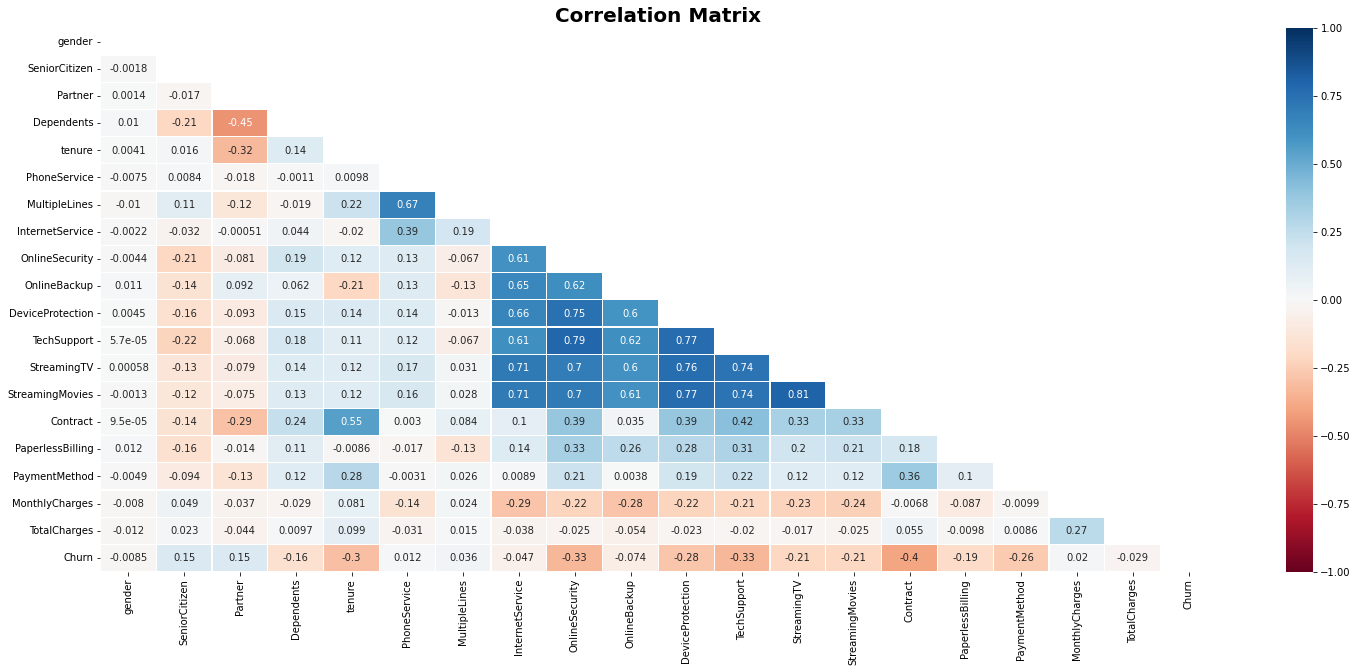

In [20]:
# feature 간의 상관관계 파악
plt.figure(figsize=(25, 10))

corr = df.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.title("Correlation Matrix", y = 1, size = 20, fontweight ="bold");
ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='RdBu', vmin=-1, vmax=1)

계약및 요금과 관련된 feature(tenure, Contract)가 높은 상관관계를 보이므로 이를 주목할 필요가 있다.

나아가 인터넷 서비스 간의 연관성이 높으므로 이 역시 확인해 볼 필요가 있다.

살펴볼 feature는 다음과 같이 3부분으로 나누었다.

인터넷 서비스와 관련된 feature

**InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies**

서비스 계약과 관련된 feature

**contract, payment method, paperless billing**

실 사용 기간과 요금 feature

**tenure, MonthlyCharges, TotalCharges**

**2-2-1. 인터넷 서비스 관련**

In [21]:

# 이탈/유지 고객 구분
retain_users = df[df['Churn'] == 'No']
churned_users = df[df['Churn'] == 'Yes']

retain_internet_users = retain_users[retain_users['InternetService'] != 'No']
churned_internet_users = churned_users[churned_users['InternetService'] != 'No']

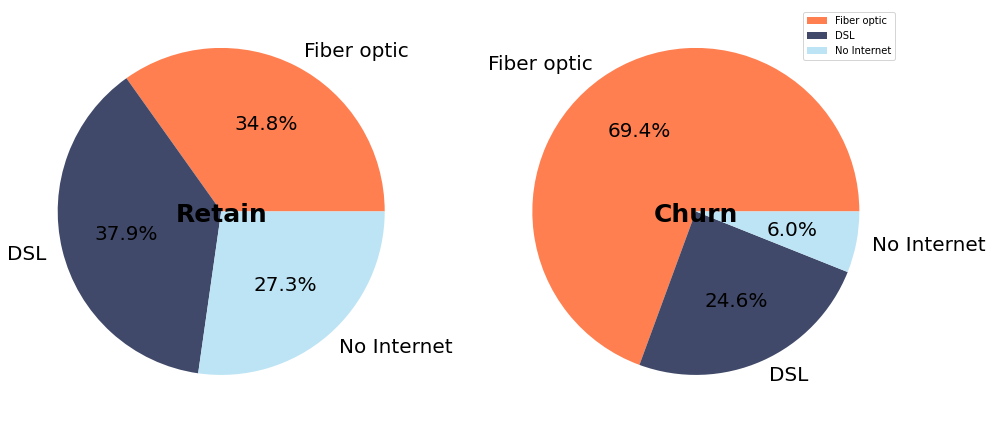

In [22]:
# 인터넷 사용 여부
# 데이터 지정
labels = ['Fiber optic','DSL','No Internet']
values_retain = [
    retain_users[retain_users['InternetService'] == 'Fiber optic'].shape[0],
    retain_users[retain_users['InternetService'] == 'DSL'].shape[0],
    retain_users[retain_users['InternetService'] == 'No'].shape[0]
]

values_churned = [
    churned_users[churned_users['InternetService'] == 'Fiber optic'].shape[0],
    churned_users[churned_users['InternetService'] == 'DSL'].shape[0],
    churned_users[churned_users['InternetService'] == 'No'].shape[0]
]

# 시각화
fig, ax = plt.subplots(1, 2, figsize=(14, 9))

ax[0].pie(values_retain, labels=labels, autopct='%0.1f%%', colors = ['#FF7F50','#404969','#BDE4F4'], textprops = {"fontsize":20})
ax[0].set_title("Retain", y = 0.46, size = 25, fontweight ="bold")


ax[1].pie(values_churned, labels=labels, autopct='%0.1f%%', colors = ['#FF7F50','#404969','#BDE4F4'], textprops = {"fontsize":20})
ax[1].set_title("Churn", y = 0.46, size = 25, fontweight ="bold")

plt.legend(loc='upper right');
plt.tight_layout();

서비스 유지 고객과 달리, 이탈 고객의 상당수(약 70%)는 광섬유 인터넷을 사용한 것으로 확인되었다.

광섬유 인터넷은 속도가 빠르지만 상대적으로 높은 가격대의 상품이다.

이후 요금 관련 feature와 관련지어 살펴 볼 필요가 있다.

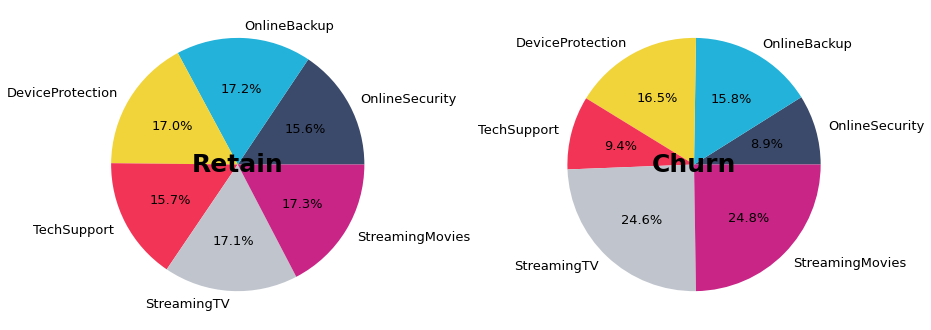

In [23]:
# 인터넷 서비스 사용
# 데이터 지정
labels = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
values_retain_internet_ser = [
    retain_internet_users[retain_internet_users['OnlineSecurity'] == 'Yes'].shape[0],
    retain_internet_users[retain_internet_users['OnlineBackup'] == 'Yes'].shape[0],
    retain_internet_users[retain_internet_users['DeviceProtection'] == 'Yes'].shape[0],
    retain_internet_users[retain_internet_users['TechSupport'] == 'Yes'].shape[0],
    retain_internet_users[retain_internet_users['StreamingTV'] == 'Yes'].shape[0],
    retain_internet_users[retain_internet_users['StreamingMovies'] == 'Yes'].shape[0]
]

values_churned_internet_ser = [
    churned_internet_users[churned_internet_users['OnlineSecurity'] == 'Yes'].shape[0],
    churned_internet_users[churned_internet_users['OnlineBackup'] == 'Yes'].shape[0],
    churned_internet_users[churned_internet_users['DeviceProtection'] == 'Yes'].shape[0],
    churned_internet_users[churned_internet_users['TechSupport'] == 'Yes'].shape[0],
    churned_internet_users[churned_internet_users['StreamingTV'] == 'Yes'].shape[0],
    churned_internet_users[churned_internet_users['StreamingMovies'] == 'Yes'].shape[0]
]

# 시각화
fig, ax = plt.subplots(1, 2, figsize=(13, 8))

ax[0].pie(values_retain_internet_ser, labels=labels, autopct='%0.1f%%', colors = ['#3B4A6B','#22B2DA','#F0D43A','#F23557','#C0C5CD','#C82586'], textprops = {"fontsize":13})
ax[0].set_title("Retain", y = 0.46, size = 25, fontweight ="bold")

ax[1].pie(values_churned_internet_ser, labels=labels, autopct='%0.1f%%', colors =['#3B4A6B','#22B2DA','#F0D43A','#F23557','#C0C5CD','#C82586'], textprops = {"fontsize":13})
ax[1].set_title("Churn", y = 0.46, size = 25, fontweight ="bold")

plt.tight_layout();

인터넷 서비스 사용 부분에서 눈에 띄는 특징은 없어 보인다.

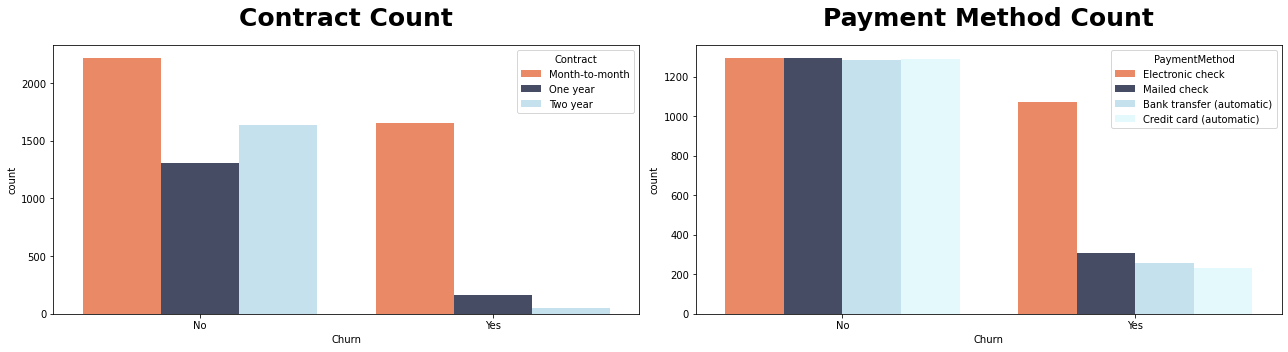

In [24]:
f, axes = plt.subplots(1, 2, figsize=(18, 5))

# 색 지정
colors1 = ['#FF7F50','#404969','#BDE4F4']
colors2 = ['#FF7F50','#404969','#BDE4F4', '#E0FCFF']

#시각화
sns.countplot(data=df, x='Churn', hue='Contract', ax=axes[0], palette=colors1);
axes[0].set_title("Contract Count", y = 1.05, size = 25, fontweight ="bold")

sns.countplot(data=df, x='Churn', hue='PaymentMethod', ax=axes[1], palette=colors2);
axes[1].set_title("Payment Method Count", y = 1.05, size = 25, fontweight ="bold")

plt.tight_layout();

**계약 기간이 짧은 고객일 수록 이탈률이 높은 것**을 확인할 수 있다.
특히 매월 갱신하는 계약의 경우, 눈에 띄는 고객 이탈을 확인할 수 있다.

계약을 매월 갱신하는 상황에서는 지속적으로 서비스에 대해 생각하게 될 것이다.
만일 2년 단위로 계약을 갱신하는 고객이라면, 서비스를 이용하지 않더라도 이에 관해 잊고 있을수도 있고 혹은 이왕 결제를 했으니 이용해보자 하는 생각이 들 수도 있을 것이다.

하지만 매월 갱신하는 계약의 경우, 해당 서비스에 대해 끊임없이 판단해야 하는 상황에 놓일 것이므로 작은 불만에도 쉽게 이탈할 가능성이 있다. 특히 자동 결제가 아닌 다른 결제 방식에서 이탈률이 높은 것으로 보아, 매번 요금에 비해 충분한 서비스를 받고 있는지 생각했을 가능성이 있다.

**2-2-3. 실 사용 기간 및 요금 관련**

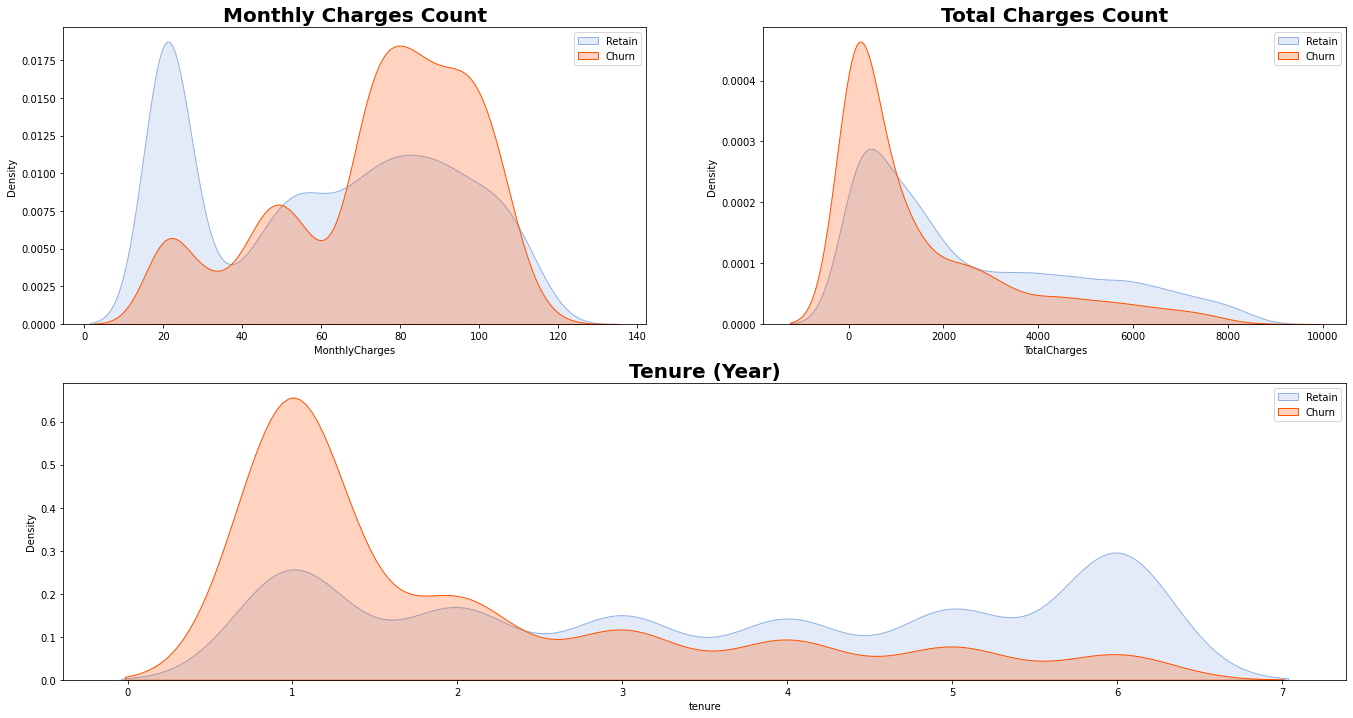

In [25]:
# 색 지정
colors = ['#90B2E4', '#FF5200']
sns.set_palette(sns.color_palette(colors))
fig = plt.figure(figsize=(23, 12)) 

#시각화
plt.subplot(221)
sns.kdeplot(df.MonthlyCharges[(df["Churn"] == 'No') ], shade = True);
sns.kdeplot(df.MonthlyCharges[(df["Churn"] == 'Yes') ], shade = True);
plt.legend(["Retain","Churn"],loc='upper right');
plt.title("Monthly Charges Count", size = 20, fontweight ="bold")

plt.subplot(222)
sns.kdeplot(df.TotalCharges[(df["Churn"] == 'No') ], shade = True);
sns.kdeplot(df.TotalCharges[(df["Churn"] == 'Yes') ], shade = True);
plt.legend(["Retain","Churn"],loc='upper right');
plt.title("Total Charges Count", size = 20, fontweight ="bold")

plt.subplot(212)
sns.kdeplot(df.tenure[(df["Churn"] == 'No') ], shade = True);
sns.kdeplot(df.tenure[(df["Churn"] == 'Yes') ], shade = True);
plt.legend(["Retain","Churn"],loc='upper right');
plt.title("Tenure (Year)", size = 20, fontweight ="bold")

plt.show()

한 달동안 이탈 고객은 서비스 유지 고객에 비해 평균적으로 **2배 이상 많은 요금을 지불**하고 있다.

위의 계약을 한 달마다 갱신하는 것과 관련지어 생각한다면, 이탈 고객은 상대적으로 많은 요금을 매월 마주해야 하기 때문에 서비스에 대한 부담감이 생길 수 있는 것이다.

또한 이탈 고객이 가격이 높은 광섬유 인터넷의 비율이 높은 것을 생각해 본다면 그들의 많은 요금도 이해가 된다.

나아가 대다수의 이탈 고객은 **1~2년 사이에 서비스를 중단**하는 것으로 확인된다.

# Step 3. Modeling

EDA를 통해 얻은 인사이트를 적용할 수 있도록, 이탈 가능성이 있는 고객을 선별하는 모델을 만들고자 한다.


**3-1. Target 및 데이터 셋 설정**

데이터 셋 전처리

In [26]:
def object_to_int(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

In [27]:
data = df.apply(lambda x: object_to_int(x))

In [28]:

data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,3,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,1,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,4,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


데이터 셋 설정

In [29]:
# 타겟 설정
target = 'Churn'
features = data.columns.drop(target)

In [30]:
# 훈련/검증/테스트 세트 분리
train, test = train_test_split(data, test_size=0.20, 
                              stratify=data[target], random_state=2)
train, val = train_test_split(train, test_size=0.20, 
                              stratify=train[target], random_state=2)

train.shape, val.shape, test.shape

((4500, 20), (1125, 20), (1407, 20))

In [31]:
# 훈련/검증/테스트 데이터를 특성과 타겟으로 분리
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [32]:
# 타겟 비율 확인
train[target].value_counts(normalize=True)  ## 비대칭 -> 차후 불균형 클래스 보완 필요

0    0.734222
1    0.265778
Name: Churn, dtype: float64

In [33]:
# 기준모델의 정확도 계산
major = data[target].mode().loc[0]

y_pred = [major] * len(data[target])
print("Baseline Accuracy Score : ", accuracy_score(data[target], y_pred))

Baseline Accuracy Score :  0.7342150170648464


**3-2. Modeling**

In [34]:
# 모델 평가 모듈

## 오차행렬(Confusion Matrix) 시각화 모듈
def confusion_matrix(model, y_pred):
    fig, ax = plt.subplots(figsize=(8, 8))
    pcm = plot_confusion_matrix(model, X_val, y_val,
                                cmap='PuBu',
                                ax=ax, values_format =".1f");
    plt.title(f'Confusion matrix', y = 1.05, fontsize=15, fontweight ="bold")
    plt.show();

    print('\n','---------------- Classification Report ----------------')
    print(classification_report(y_val, y_pred))


## ROC_curve 시각화 모듈
def ROC_curve(model, y_pred, y_prob):
    fpr, tpr, thresholds = roc_curve(y_val, y_prob)

    # 시각화
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='#1F507C')
    plt.scatter(fpr, tpr, color='#FFAA4C')
    plt.title('ROC curve', y = 1.05, fontsize=15, fontweight ="bold")
    plt.xlabel('FPR(Fall-out)')
    plt.ylabel('TPR(Recall)')
    auc_score_lr = roc_auc_score(y_val, y_pred)

    # AUC Socre 확인
    print(f'AUC Score : {auc_score_lr}')


## 모델 비교 모듈
def evaluate(y_real,y_pred, y_prob):
    acc = accuracy_score(y_real, y_pred)
    rec = recall_score(y_real, y_pred)
    f1 = f1_score(y_real, y_pred)
    auc = roc_auc_score(y_real, y_prob)
    print('Accuracy : {:.6f}'.format(acc)) #정확도 : 예측이 정답과 얼마나 정확한가
    print('Recall : {:.6f}'.format(rec)) #재현율 : 정답 중에서 예측한 것의 비율
    print('F1 score : {:.6f}'.format(f1)) #정밀도와 재현율의 (조화)평균 - 정밀도와 재현율이 비슷할수록 높은 점수
    print('ROC curve_auc score : {:.6f}'.format(auc))
    
    score_list = [acc,rec,f1,auc]
    score_box = np.array(score_list)
    return score_box

model_box = pd.DataFrame(columns=['Logistic','XgBoost','SVC','AdaBoost'],
                         index = ['accuracy','recall','f1 score','roc_auc'])

**3-2-1. Logistic Regression**

1) model 학습

In [35]:
pipe_lr = make_pipeline(
    CatBoostEncoder(),
    PowerTransformer(),
    LogisticRegression(random_state=2, class_weight='balaced')
)

pipe_lr.fit(X_train, y_train);

**2) model 평가**

Confusion Matrix

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


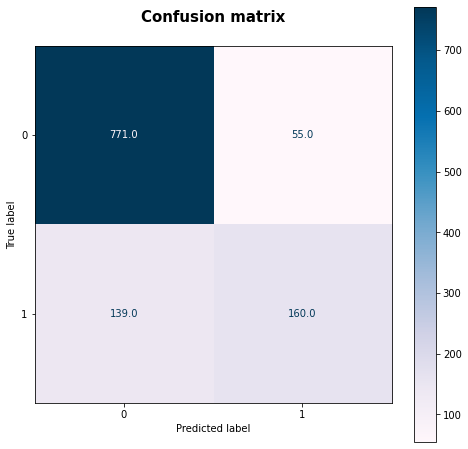


 ---------------- Classification Report ----------------
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       826
           1       0.74      0.54      0.62       299

    accuracy                           0.83      1125
   macro avg       0.80      0.73      0.76      1125
weighted avg       0.82      0.83      0.82      1125



In [36]:
# 불러온 모델에 검증데이터(X_val)로 예측값과 예측확률을 산출
lr_pred = pipe_lr.predict(X_val)
lr_prob = pipe_lr.predict_proba(X_val)[:, 1]

# Logistic Regression 오차행렬
confusion_matrix(pipe_lr, lr_pred)

ROC curve, AUC

AUC Score : 0.7342655502198612


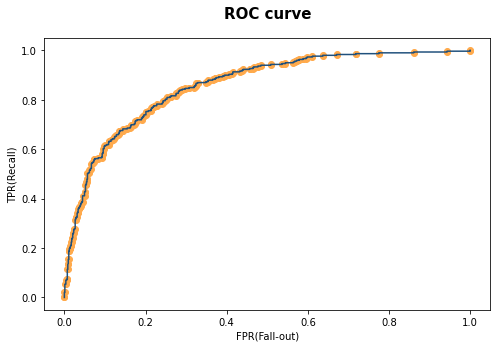

In [37]:
# Logistic Regression ROC 커브
ROC_curve(pipe_lr, lr_pred, lr_prob)

**3) Hyperparam Tuning**

In [38]:
param_lr = {
    'logisticregression__penalty': ['l2', 'l1', 'elasticnet', 'none'],
    'logisticregression__class_weight': ['balanced'],
    'logisticregression__C': [1.0, 0.9, 0.8],
    'logisticregression__max_iter': [300],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__l1_ratio': [1.0, 0.0, 0.3],
}

clf_lr = GridSearchCV(
   estimator=pipe_lr,
   scoring='balanced_accuracy',
   param_grid=param_lr,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

clf_lr.fit(X_train, y_train);

Fitting 5 folds for each of 180 candidates, totalling 900 fits



360 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_s

In [39]:
# 최적의 하이퍼파라미터를 적용해, Test DataSet로 모델 평가
pipe_lr2 = clf_lr.best_estimator_

lr2_pred = pipe_lr2.predict(X_test)
lr2_prob = pipe_lr2.predict_proba(X_test)[:, 1]

model_box['Logistic'] = evaluate(y_test, lr2_pred, lr2_prob)

Accuracy : 0.757640
Recall : 0.804813
F1 score : 0.638388
ROC curve_auc score : 0.858193


**3-2-2. Xgboost**

1) model 학습

In [40]:
pipe_xg = make_pipeline(
    CatBoostEncoder(),
    PowerTransformer(),
    XGBClassifier(random_state=2, n_estimators=100, class_weight='balanced')
)

pipe_xg.fit(X_train, y_train);

2) model 평가

Confusion Matrix

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


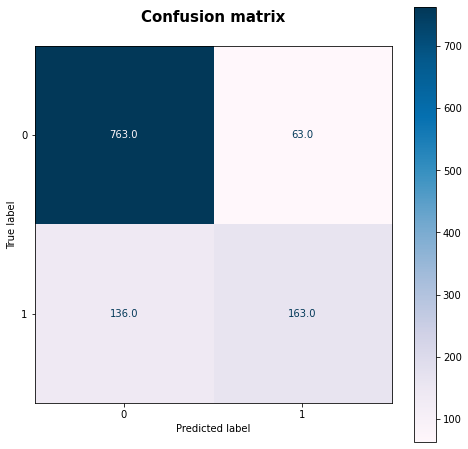


 ---------------- Classification Report ----------------
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       826
           1       0.72      0.55      0.62       299

    accuracy                           0.82      1125
   macro avg       0.78      0.73      0.75      1125
weighted avg       0.81      0.82      0.81      1125



In [41]:
# 불러온 모델에 검증데이터(X_val)로 예측값과 예측확률을 산출
xg_pred = pipe_xg.predict(X_val)
xg_prob = pipe_xg.predict_proba(X_val)[:, 1]

# Xgboost 오차행렬
confusion_matrix(pipe_xg, xg_pred)

ROC curve, AUC

AUC Score : 0.7344396576157813


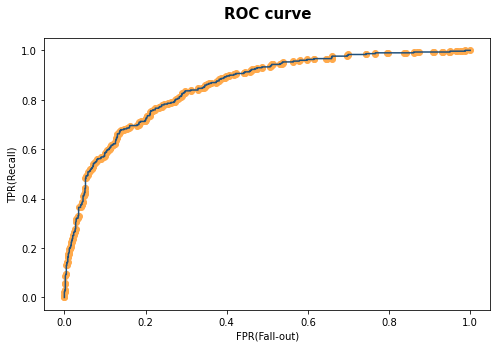

In [42]:
# XGBoost ROC 커브
ROC_curve(pipe_xg, xg_pred, xg_prob)

3) Hyperparam Tuning

In [43]:

param_xg = {
    'xgbclassifier__criterion': ['entrophy', 'gini'],
    'xgbclassifier__max_depth': np.arange(1, 10),
    'xgbclassifier__max_leaf_nodes': np.arange(1, 30, 5),
    'xgbclassifier__min_samples_leaf': np.arange(10, 30, 5)
    
}

clf_xg = GridSearchCV(
   estimator=pipe_xg,
   scoring='balanced_accuracy',
   param_grid=param_xg,
   cv=3,
   n_jobs=-1, 
   verbose=3
)

clf_xg.fit(X_train, y_train);

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


In [44]:

# 최적의 하이퍼파라미터를 적용해, Test DataSet로 모델 평가
pipe_xg2 = clf_xg.best_estimator_

xg2_pred = pipe_xg2.predict(X_test)
xg2_prob = pipe_xg2.predict_proba(X_test)[:, 1]

model_box['XgBoost'] = evaluate(y_test, xg2_pred, xg2_prob)

Accuracy : 0.794598
Recall : 0.508021
F1 score : 0.568012
ROC curve_auc score : 0.853421


**3-2-3. SVC**

1) model 학습

In [45]:
pipe_svc = make_pipeline(
    CatBoostEncoder(),
    PowerTransformer(),
    SVC(random_state = 2, probability=True)
)

pipe_svc.fit(X_train, y_train);

2) model 평가

Confusion Matrix

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


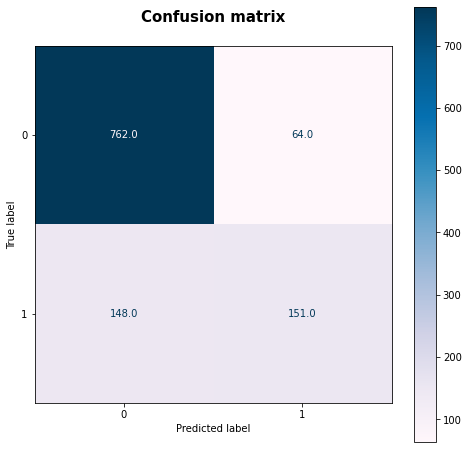


 ---------------- Classification Report ----------------
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       826
           1       0.70      0.51      0.59       299

    accuracy                           0.81      1125
   macro avg       0.77      0.71      0.73      1125
weighted avg       0.80      0.81      0.80      1125



In [46]:
# 불러온 모델에 검증데이터(X_val)로 예측값과 예측확률을 산출
svc_pred = pipe_svc.predict(X_val)
svc_prob = pipe_svc.predict_proba(X_val)[:, 1]

# SVC 오차행렬
confusion_matrix(pipe_svc, svc_pred)

ROC curve, AUC

AUC Score : 0.713767441107161


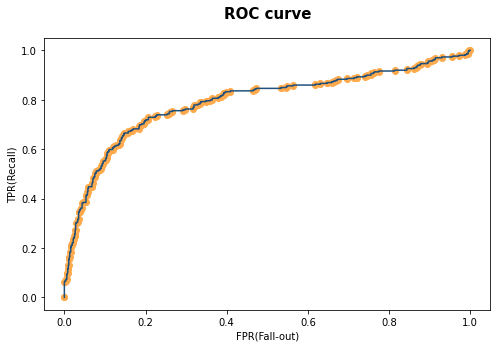

In [47]:
# SVC ROC 커브
ROC_curve(pipe_svc, svc_pred, svc_prob)

3) Hyperparam Tuning

In [48]:
param_svc = {
    'svc__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
}

clf_svc = GridSearchCV(
   estimator=pipe_svc,
   scoring='balanced_accuracy',
   param_grid=param_svc,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

clf_svc.fit(X_train, y_train);

Fitting 5 folds for each of 64 candidates, totalling 320 fits


**3-2-4. AdaBoost**

1) model 학습

In [49]:
# 최적의 하이퍼파라미터를 적용해, Test DataSet로 모델 평가
pipe_svc2 = clf_svc.best_estimator_

svc2_pred = pipe_svc2.predict(X_test)
svc2_prob = pipe_svc2.predict_proba(X_test)[:, 1]

model_box['SVC'] = evaluate(y_test, svc2_pred, svc2_prob)

Accuracy : 0.795309
Recall : 0.465241
F1 score : 0.547170
ROC curve_auc score : 0.854248


2) model 평가

Confusion Matrix

In [50]:
pipe_ada = make_pipeline(
    CatBoostEncoder(),
    PowerTransformer(),
    AdaBoostClassifier(random_state=2, n_estimators=100)
)

pipe_ada.fit(X_train, y_train);

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


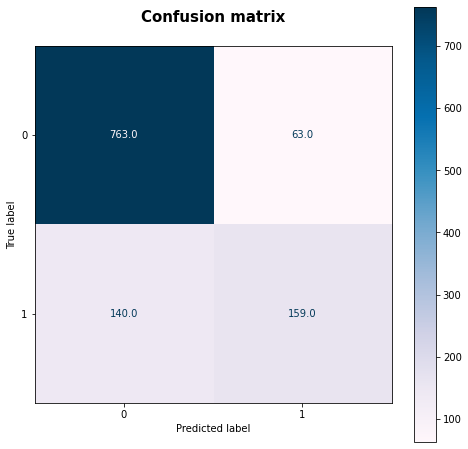


 ---------------- Classification Report ----------------
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       826
           1       0.72      0.53      0.61       299

    accuracy                           0.82      1125
   macro avg       0.78      0.73      0.75      1125
weighted avg       0.81      0.82      0.81      1125



In [51]:
# 불러온 모델에 검증데이터(X_val)로 예측값과 예측확률을 산출
ada_pred = pipe_ada.predict(X_val)
ada_prob = pipe_ada.predict_proba(X_val)[:, 1]

# AdaBoost 오차행렬
confusion_matrix(pipe_ada, ada_pred)

ROC curve, AUC

AUC Score : 0.727750694405079


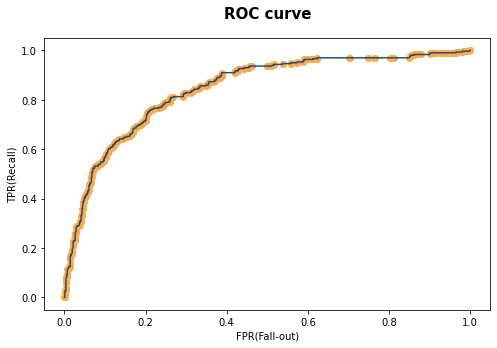

In [52]:
# AdaBoost ROC 커브
ROC_curve(pipe_ada, ada_pred, ada_prob)

3) Hyperparam Tuning

In [53]:
param_ada = {
    'adaboostclassifier__n_estimators' : [100, 500],
    'adaboostclassifier__learning_rate' : [0.05, 0.1, 0.5, 1]
}

clf_ada = GridSearchCV(
   estimator=pipe_ada,
   scoring='balanced_accuracy',
   param_grid=param_ada,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

clf_ada.fit(X_train, y_train);

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [54]:
# 최적의 하이퍼파라미터를 적용해, Test DataSet로 모델 평가
pipe_ada2 = clf_ada.best_estimator_

ada2_pred = pipe_ada2.predict(X_test)
ada2_prob = pipe_ada2.predict_proba(X_test)[:, 1]

model_box['AdaBoost'] = evaluate(y_test, ada2_pred, ada2_prob)

Accuracy : 0.793177
Recall : 0.532086
F1 score : 0.577649
ROC curve_auc score : 0.855755


**3-2-5. Model 비교**

In [55]:
model_box_t = model_box.T
model_box_t = model_box_t*100

model_box_t.sort_values(by=['recall'], ascending=False, inplace=True)
model_box_t.style.background_gradient(cmap='Blues').format("{:.1f}")

,accuracy,recall,f1 score,roc_auc
Logistic,75.8,80.5,63.8,85.8
AdaBoost,79.3,53.2,57.8,85.6
XgBoost,79.5,50.8,56.8,85.3
SVC,79.5,46.5,54.7,85.4


고객 이탈을 예측하는 문제에 있어서 오류는 두 가지가 있을 것이다.

이탈할 사람을 이탈하지 않을 것이라 잘못 예측하는 경우(낮은 재현율 recall)

이탈하지 않을 사람을 이탈할 것이라 잘못 예측하는 경우(낮은 정밀도 precision)

회사의 입장에서는 전자의 오류가 더 중요한 문제이다.
후자의 경우 이탈하지 않을 사람을 대상으로 예산을 낭비하는 문제가 발생하지만,
전자와 같이 잘못 예측한다면 고객은 이탈해 버리고 말 테니 말이다.

따라서 모델 제작에 있어서 재현율을 높이는 것에 집중하고자 한다.
가장 높은 재현율(recall)을 보여주는 모델은 80.5를 기록한 Logistic Regression이다.

# Step 4. Interpreting ML Model
**4-1. Feature Importance**

In [56]:
best_model = clf_lr.best_estimator_

In [57]:
permuter = PermutationImportance(
    best_model, # model
    scoring='balanced_accuracy',
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

permuter.fit(X_val, y_val);

# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=X_val.columns.tolist() 
)

Weight,Feature
0.1721 ± 0.0152,TotalCharges
0.1149 ± 0.0263,MonthlyCharges
0.0330 ± 0.0144,Contract
0.0078 ± 0.0060,TechSupport
0.0065 ± 0.0084,PhoneService
0.0041 ± 0.0103,tenure
0.0029 ± 0.0098,InternetService
0.0014 ± 0.0041,Dependents
0.0009 ± 0.0009,PaymentMethod
0.0008 ± 0.0037,StreamingMovies


**요금**과 **서비스 계약**과 관련된 요인이 고객 이탈에 있어서 가장 큰 요소임을 확인할 수 있다.

# 4-2. Shap을 통한 개별 예측 설명

In [58]:
shap.initjs()

explainer = shap.LinearExplainer(pipe_lr2.named_steps["logisticregression"], masker=shap.maskers.Impute(data=X_train), feature_names=X_train.columns, algorithm="linear")
shap_values = explainer.shap_values(pipe_lr2[:-1].transform(X_test))

shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[[4]], link="logit")

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

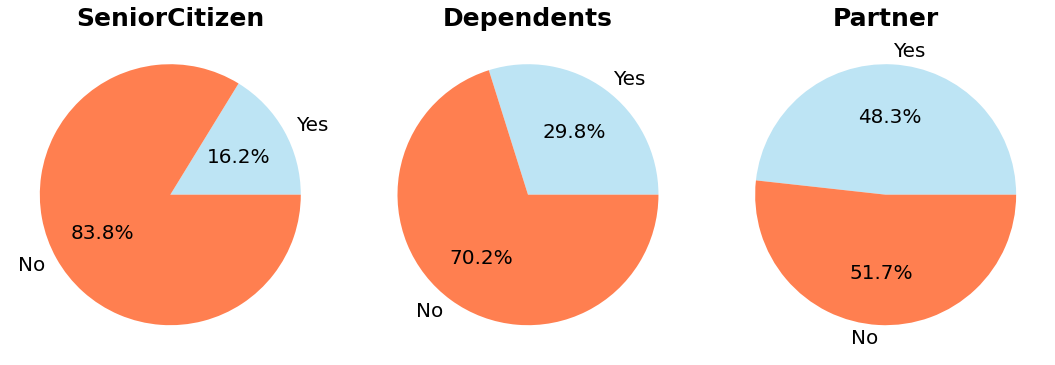

In [59]:
# 데이터 정리
# 고객이 노인인지 여부
labels = ['Yes', 'No']

values_SeniorCitizen = [
    df[df['SeniorCitizen'] == 'Yes'].shape[0],
    df[df['SeniorCitizen'] == 'No'].shape[0],
]

# 고객에게 부양 가족이 있는지 여부
values_Dependents = [
    df[df['Dependents'] == 'Yes'].shape[0],
    df[df['Dependents'] == 'No'].shape[0],
]

# 고객에게 파트너가 있는지 여부
values_Partner = [
    df[df['Partner'] == 'Yes'].shape[0],
    df[df['Partner'] == 'No'].shape[0],
]


# 시각화
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].pie(values_SeniorCitizen, labels=labels, autopct='%0.1f%%', colors = ['#BDE4F4','#FF7F50'], textprops = {"fontsize":20})
ax[0].set_title("SeniorCitizen", size = 25, fontweight ="bold")

ax[1].pie(values_Dependents, labels=labels, autopct='%0.1f%%', colors = ['#BDE4F4','#FF7F50'], textprops = {"fontsize":20})
ax[1].set_title("Dependents", size = 25, fontweight ="bold")

ax[2].pie(values_Partner, labels=labels, autopct='%0.1f%%', colors = ['#BDE4F4','#FF7F50'], textprops = {"fontsize":20})
ax[2].set_title("Partner", size = 25, fontweight ="bold")

plt.tight_layout();

# 향후 서비스 기획 제안 1 : 타겟팅 요금제

이탈 고객에게 있어서 가장 큰 걸림돌은 **비싼 요금**이었다.
서비스 유지 고객에 비해 이탈고객은 **평균적으로 2배 이상 많은 요금을 지불**하고 있으며,
또한 **광섬유 인터넷**을 선택하는 비율이 높은 것으로 보아 빠른 인터넷을 선호하는 고객층으로 예상된다.

서비스를 이용하는 전체 고객의 연령대 추측 결과, **부양가족/파트너가 없는 2040**이 대부분일 것으로 추정된다.

따라서 이들을 위한, 비교적 저렴하지만 빠른 인터넷을 포함한 요금제를 제안하고자 한다.

실제로 국내 통신사에서는 20대, 혹은 대학생만을 위한 요금제를 선보이기도 하였다.

SKT : 0한동

KT : Y슈퍼플랜

# 향후 서비스 기획 제안 2 : 장기 계약 이벤트

이탈 고객은 매월 계약을 갱신하는 상품을 선택하는 비율이 높으며,
대부분 **1~2년 사이에 서비스를 중단**하는 것으로 확인된다.

이러한 이탈을 막기 위해 단기간 계약 갱신 상품을 이용하는 고객을 대상으로, 장기간 상품으로 전환 시 추첨을 통해 상품을 주는 간단한 **경품 이벤**트 혹은 **단기간 요금 할인 이벤트**를 열어도 좋을 것으로 기대된다.

또한 신규 가입자가 장기 구독 상품을 구매하는 경우 받을 수 있는 **첫 달 한정 이벤트**를 함께 해, 신규 유입도 고려한다면 좋을 것이다.

# 향후 서비스 기획 제안 3 : 이탈 원인 데이터화
구독 서비스를 해지하려 했을 때, 해지하시는 이유를 알려주세요와 같은 팝업창을 마주한 적이 있을 것이다.

이는 **이탈 원인을 데이터화**하는 것으로, 차후 이탈 고객을 다루는 데에 도움이 될 것이다.